In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display  
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
from sklearn import kernel_ridge
import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import timeit

from sklearn import svm

In [2]:
# Load the 2 files
dfWhite = pd.read_csv('../data/winequality-white.csv', sep=";")
dfRed = pd.read_csv('../data/winequality-red.csv', sep=";")

In [31]:
X = dfWhite.drop('quality', axis=1)  # Exclude the target column
y = dfWhite['quality']

In [32]:
dfWhite.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [33]:
X.shape

(4898, 11)

In [34]:
y.shape

(4898,)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_class

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [62]:
def kernelRidge(gamma):
    predicteur = kernel_ridge.KernelRidge(
        alpha=1.0, # valeur par défaut 
        kernel='rbf', # noyau Gaussien
        gamma=gamma)   # valeur de 1/(2 * sigma**2)
    
    # entraîner le classifieur sur le jeu d'entrainement
    predicteur.fit(X_train_std, y_train)
    
    y_test_pred = predicteur.predict(X_test_std)
    
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    print("RMSE: {:.2f}".format(rmse))

    # Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
    # le nombre de ces paires.
    # Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants 
    # dans un nuage de points
    sizes = {}
    for (yt, yp) in zip(list(y_test), list(y_test_pred)):
        if (yt, yp) in sizes.keys():
            sizes[(yt, yp)] += 1
        else:
            sizes[(yt, yp)] = 1        
    keys = sizes.keys()
    
    # afficher les prédictions
    plt.scatter([k[0] for k in keys], 
                [k[1] for k in keys], 
                 s=[sizes[k] for k in keys], 
                label=f"gamma = {gamma}: RMSE = {rmse}")


RMSE: 0.72
RMSE: 5.26


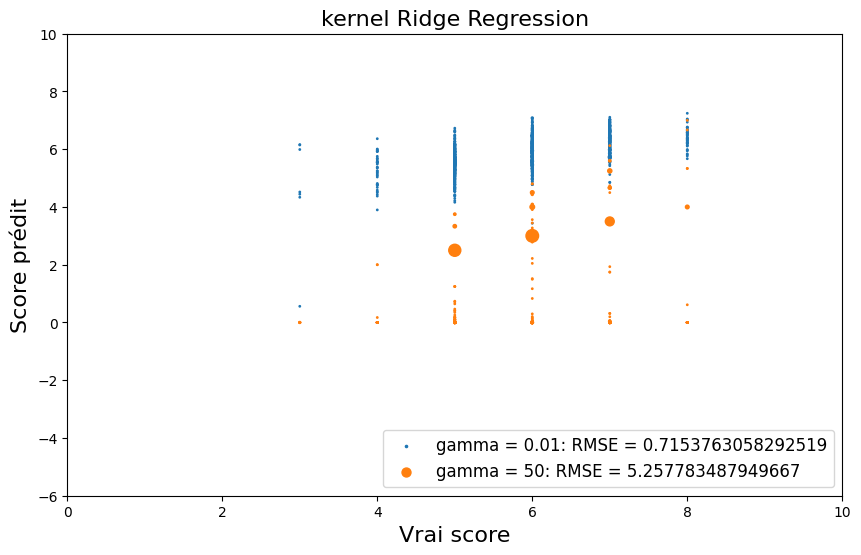

In [70]:
fig = plt.figure(figsize=(10, 6))
kernelRidge(0.01)
kernelRidge(50)

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([0, 10])
plt.ylim([-6, 10])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

In [71]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_train_std, y_train)

# prédire sur le jeu de test avec le modèle sélectionné 
y_test_pred_cv = grid_pred.predict(X_test_std)

# calculer la RMSE correspondante
rmse_cv = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cv))

{'alpha': 0.01, 'gamma': 0.01}

RMSE: 0.72
RMSE: 5.26


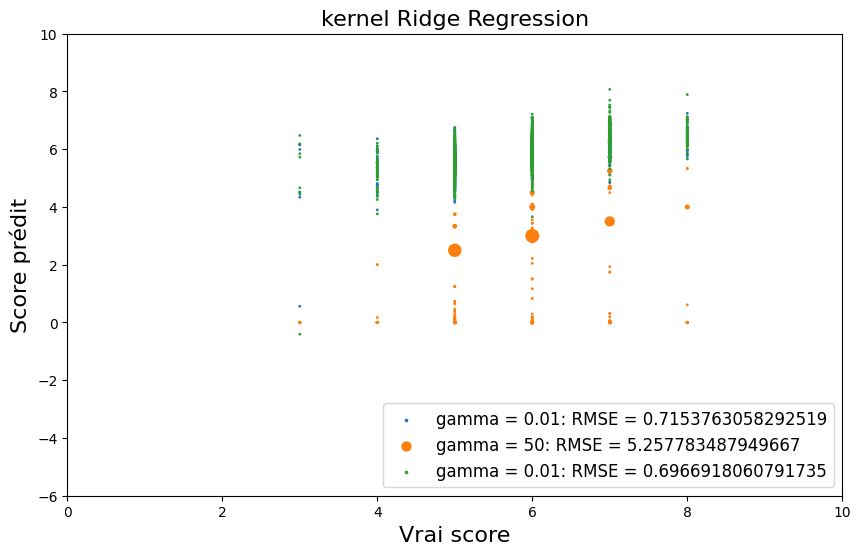

In [81]:
fig = plt.figure(figsize=(10, 6))

kernelRidge(0.01)
kernelRidge(50)

sizes = {}
for (yt, yp) in zip(list(y_test), list(y_test_pred_cv)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label=f"gamma = {grid_pred.best_params_['gamma']}: RMSE = {rmse_cv}")

# étiqueter les axes eabst le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([0, 10])
plt.ylim([-6, 10])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)